***Méthodes numériques: Module 2***
***********************************
Space and Time: Modélisation de l'écoulement du trafic.
==
## Introduction #

Dans ce module nous allons résoudre une équation non-linéaire à deux variables en discrétisant à la fois dans le temps (en utilisant la forward-difference) et dans l'espace (en utilisant la backward-difference). Nous utiliserons également les nouveaux outils introduit dans ce module: sympy et lambdify, qui nous permettrons d'écrire des formules mathématiques dans nos codes et d'utiliser des fonctions de manière plus confortable. 

Comme dans le module 1, nous importons la librairie numpy et matplotlib pour pouvoir dessiner des graphiques, mais également sympy et lambdify.

In [1]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

## Principe #

L'équation que l'on se propose de résoudre est la suivante: $$\frac{\partial{\rho}}{\partial{t}}+\frac{\partial{F}}{\partial{x}}=0$$ 

Cette équation modélise le flux du trafic de voitures sur l'autoroute. Il s'agit en fait de l'équation non-linéaire de convection appliquée à la densité de voiture, $\rho$. La fonction F représente le flux des voitures donné par $F=V \rho$ où V est la vitesse moyenne des voitures.

On modélise le fait que la vitesse varie en fonction de la densité de voiture en exprimant que la vitesse est maximale quand la densité de voiture est nulle et qu'elle est nulle quand la densité de voiture atteind une densité critique que l'on appelle $\rho_{max}$, ce qui se traduit par la formule suivante: 

$$V = V_{max}(1-\frac{\rho}{\rho_{max}})$$

Nous voulons discrétiser notre équation en utilisant l'approximation de la dérivée vers l'avant pour le temps et vers l'arrière pour l'espace, c'est-à-dire:

$$\frac{\partial{\rho}}{\partial{t}} \cong \frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t}$$ et 
$$\frac{\partial{F}}{\partial{x}} \cong \frac{F_{i}^{n} - F_{i-1}^{n}}{\Delta x}$$

### Remarques:
- Les exposants représentent les indices de temps (n) et les indices en dessous sont les indices pour l'espace (i).
- $F_{i}^{n}=F(\rho_{i}^{n})$. Nous avons d'abord pensé à développer l'équation à discrétiser en exprimant tout en termes de $\rho$, mais cela augmente l'erreur que l'on fait en discrétisant et il est préférable de discrétiser F et de calculer directement sa valeur à chaque instant et point de l'espace.

L'équation devient: $$\frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t}=\frac{F_{i}^{n} - F_{i-1}^{n}}{\Delta x}$$ 
$$\Leftrightarrow$$

$$\rho_{i}^{n+1}= \rho_{i}^{n}+\frac{\Delta t}{\Delta  x}(F_{i}^{n} - F_{i-1}^{n})$$
où à chaque étape, la seule inconnue est $\rho_{i}^{n+1}$.

## Code

Nous commencons par créer la fonction F que nous pourrons ensuite réutiliser telle quelle dans le code.

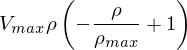

In [2]:
rho=sympy.symbols('rho')
V_max=sympy.symbols('V_max')
rho_max=sympy.symbols('rho_max')
F=rho*V_max*(1-rho/rho_max)
flamb=lambdify((rho,V_max,rho_max),F)
F

Nous allons résoudre cette équation pour différents paramètres de départ. Certains paramètres, comme la longueur sur laquelle nous étudions cette équation, seront les mêmes pour tous les cas et nous les fixons donc à l'avance. Ce sont les paramètres invariants.

### Paramètres invariants du problème.

In [3]:
L=11
rhomax=250.
nx=51
dx=L/(nx-1)
dt=.001

### Fonction: Calcul de $\rho$ et $v$.
Afin de pouvoir facilement dééterminer les solutions de l'équation en partant de conditions initiales différentes, le code qui va résoudre l'équation est mis sous forme de fonction. Cette fonction dépend de:
- $\rho$(x,0) la condition initiale (=initial)
- nt: le nombre d'étapes de discrétisation que nous voulons effectuer. Ce nombre dépend du temps auquel on veut regarder la solution et nous pourrons ainsi regarder à plusieurs temps sans devoir le code.
- $\rho$(0,t) la condition aux limites (=bound)
- $V_{max}$ la vitesse maximale des voitures atteinte lorsque la densité du trafic est (quasi) nulle. 

In [13]:
def rho(initial,numberstep,bound,vmax):
    rho00=initial.copy() #we do this step to be sure that we won't change the value of initial each time we execute the function
    for n in range(1,numberstep): 
        rhocopy = rho00.copy()
        rho00[1:] = rhocopy[1:]-dt/dx*(flamb(rhocopy[1:],vmax,rhomax)-flamb(rhocopy[0:-1],vmax,rhomax))
        rho00[0] = bound
    v=vmax*(1-rho00/rhomax)/3.6
    u=numpy.array([rho00,v,flamb(rho00,vmax,rhomax)])
    return u

## Simulation result: Part A.

In [14]:
x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50

- Voyons l'allure de cette densité répartie sur la portion de route :

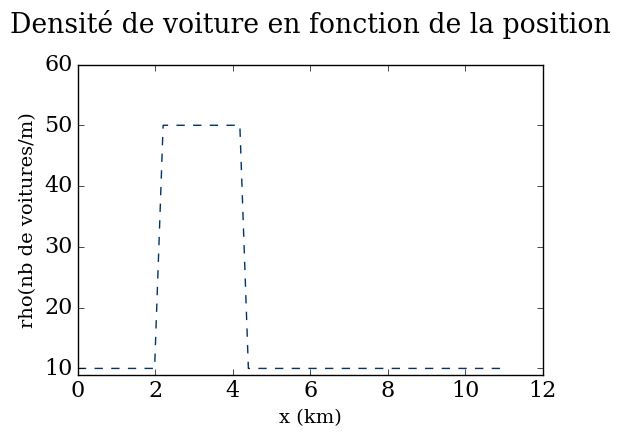

In [76]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho(nb de voitures/km)', fontsize=14) #y label
pyplot.title('Densité de voiture en fonction de la position', y=1.08)

- Voici le graphique de la densité de voitures sur le segment de longueur 11 km au temps t=nt*0.001heure. nt est le second argument de la fonction rho, on peut le changer pour voir ce qu'il se passe.

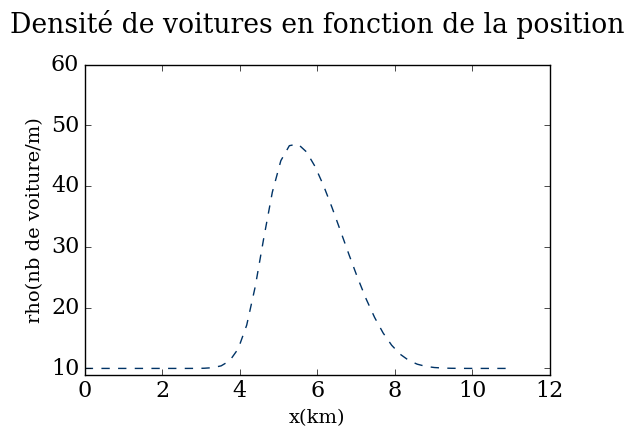

In [80]:
pyplot.plot(x,rho(rho0,42,10,80.0)[0], color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x(km)', fontsize=14) #x label
pyplot.ylabel('rho(nb de voiture/m)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08)

- On peut maintenant trouver la vitesse sur la portion de route à un certain instant grâce à la densité et à la formule : $V = V_{max}(1-\frac{\rho}{\rho_{max}})$

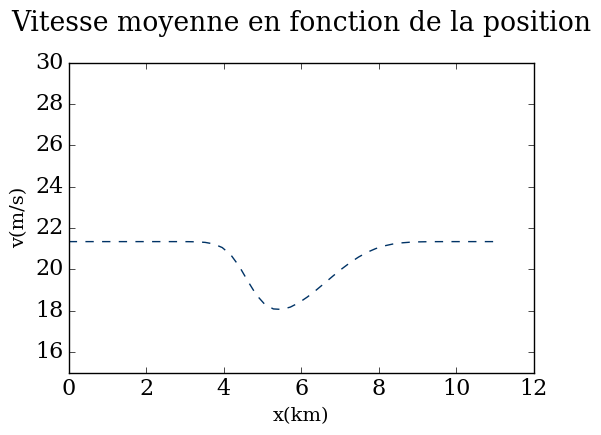

In [82]:
pyplot.plot(x,rho(rho0,42,10,80.0)[1], color='#003366', ls='--', lw=1)
pyplot.ylim(15.,30.);
pyplot.xlabel('x(km)', fontsize=14) #x label
pyplot.ylabel('v(m/s)', fontsize=14) #y label
pyplot.title('Vitesse moyenne en fonction de la position', y=1.08)

Voici enfin l'allure de la fonction F qui représente la flot du trafic en fonction de la position x sur le tronçon de 11 km.

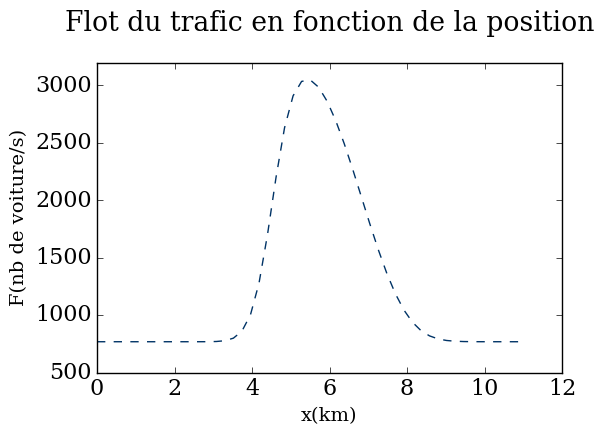

In [84]:
pyplot.plot(x,rho(rho0,42,10,80.0)[2], color='#003366', ls='--', lw=1)
pyplot.ylim(500.,3200.);
pyplot.xlabel('x(km)', fontsize=14) #x label
pyplot.ylabel('F(nb de voiture/s)', fontsize=14) #y label
pyplot.title('Flot du trafic en fonction de la position', y=1.08)

## Simulation result: Part B.

In [54]:
x = numpy.linspace(0,L,nx)
rho1 = numpy.ones(nx)*20 
rho1[10:20] = 50

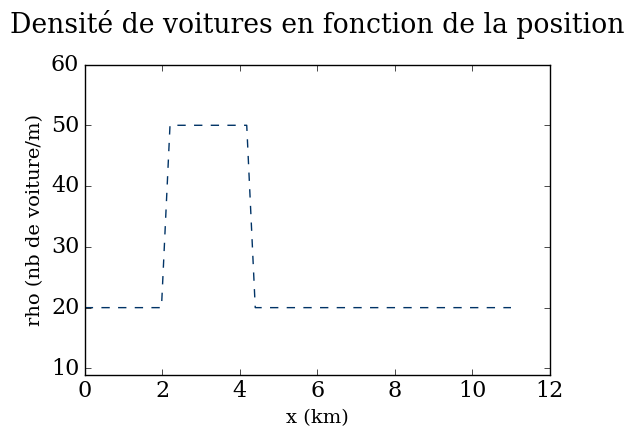

In [85]:
pyplot.plot(x, rho1, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (nb de voiture/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08)

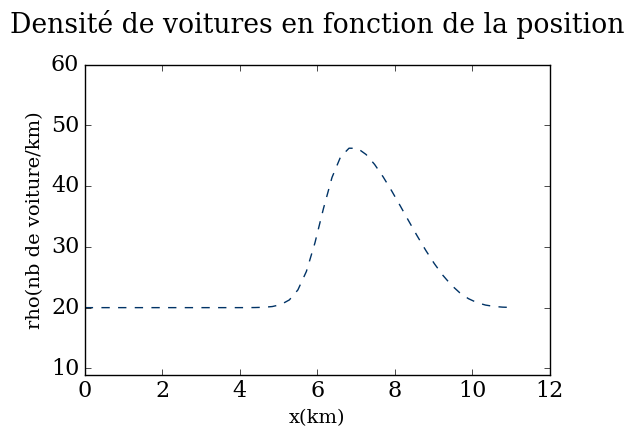

In [86]:
pyplot.plot(x,rho(rho1,42,20,136.0)[0], color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);
pyplot.xlabel('x(km)', fontsize=14) #x label
pyplot.ylabel('rho(nb de voiture/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08)

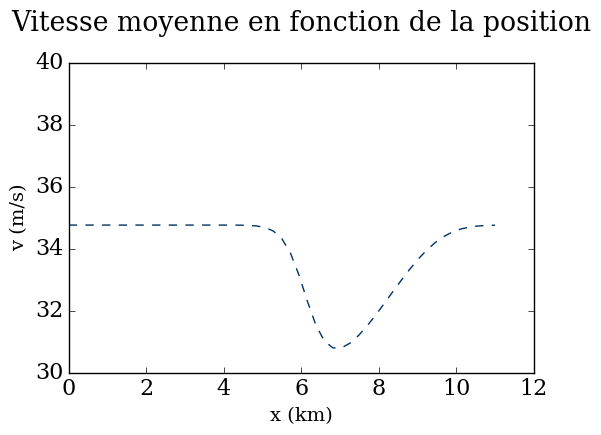

In [87]:
pyplot.plot(x,rho(rho1,42,20,136.0)[1], color='#003366', ls='--', lw=1)
pyplot.ylim(30,40);
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('v (m/s)', fontsize=14) #y label
pyplot.title('Vitesse moyenne en fonction de la position', y=1.08)

Questions

In [93]:
def time(t):
    n=int(t/0.06)+1
    return n

In [94]:
def vmin(initial,t,bound,vmax):
    vmi=rho(initial,time(t),bound,vmax)[1]
    for i in range (0,nx-1):
        if vmi[i]>vmi[i+1]:
            minim=vmi[i+1]
    return(minim) 

In [95]:
vmin(rho0,6,10,80.0)

In [96]:
vmin(rho1,3,20,136.0)

In [97]:
def vmean(initial,t,bound,vmax):
    u=rho(initial,time(t),bound,vmax)[1]
    sumu=u[0]
    for i in range(1,nx):
        sumu=sumu+u[i]
    mean=sumu/(nx)
    return mean

In [98]:
vmean(rho1,3,20,136.0)

In [99]:
vmean(rho0,3,10,80.0)

## Bonus: vidéo

In [100]:
from matplotlib import animation
from IPython.display import HTML

In [101]:
nt=150
vmax=80.
u = numpy.ones(nx)*10
u[10:20] = 50
un=numpy.ones(nx)

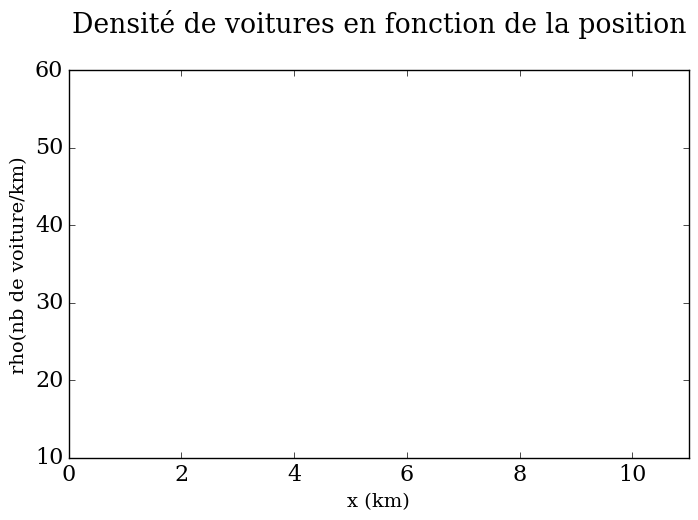

In [102]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(0,11), ylim=(10,60))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho(nb de voiture/km)', fontsize=14) #y label
pyplot.title('Densité de voitures en fonction de la position', y=1.08)

In [103]:
def density(i):
    line.set_data(x,u)
    
    un = u.copy() 
    u[1:] = un[1:]-dt/dx*(flamb(un[1:],vmax,rhomax)-flamb(un[0:-1],vmax,rhomax))
    u[0] = 10

In [104]:
anim = animation.FuncAnimation(fig, density,frames=nt, interval=100)

In [105]:
HTML(anim.to_html5_video())